In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Modeling neural tuning curves

We start with a population of neurons that are each described by Gaussian tuning curves of the form:

$$
rate = r_{max} \exp{-\dfrac{ (s-s_0)^2}{2\sigma^2}}
$$

In this equation, $s_0$ describes the prefered stimulus of the neuron, and $\sigma$ defines the tuning width. We first define a function that allows us to calculate the response of a single neuron to a particular stimulus value:


In [3]:
def gauss_tuning(s, s_0, sigma, r_max):
    return r_max*np.exp(-0.5*((s-s_0)/sigma)**2)

With this function we can simulate the responses of a population of neurons that each have aslightly different prefered stimulus value. An nice property of such a population of neurons is that the average population response will be more or less constant over most of the stimulus range.

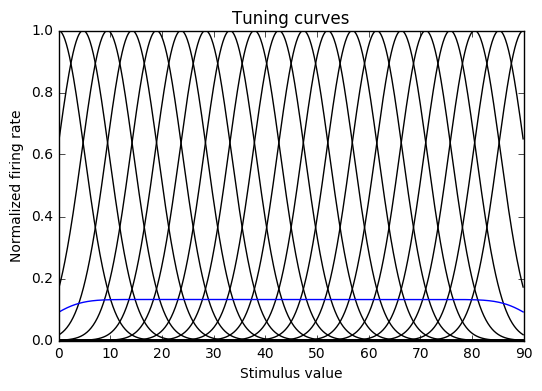

In [4]:
# Definition of tuning parameters
sigma     = 5
r_max     = 20                         
n_neurons = 20 
max_s     = 90
s_0       = np.linspace(0,max_s,n_neurons) # Prefered orientation for each neuron

# Generate neural tuning profiles
s = np.arange(0, max_s, 0.1)
neuron_tuning = np.zeros( (n_neurons, len(s)))
for i in range(n_neurons):
    neuron_tuning[i,:] = gauss_tuning(s, s_0[i], sigma, r_max) 

# Plot the tuning profiles
plt.plot(s, neuron_tuning.transpose()/r_max,color='k')
plt.plot(s, np.mean(neuron_tuning/r_max,0))
plt.xlabel('Stimulus value')
plt.ylabel('Normalized firing rate')
plt.title('Tuning curves')

## 2. Simulating neural responses
In the following example we choose the prefered stimulus of one of the neurons as input stimulus to the population of neurons. With this stimulus value we can calculate the predicted rate according to the tuning curve of each neuron. In each simulated trial, an actual spike count is obtained by using this rate as input for a Poisson generator.

The plot shows the tuning curve of the neuron that corresponds to the prefered stimulus, together with spike counts observed in a single trial, and a trial averaged spike count. Note that the firing rates produced by the tuning curves are expressed in Hz, but we simulate only for 0.5 seconds. Therefore, the obtained spike counts are normalized with respect to time so that they can be mapped onto the tuning curve.

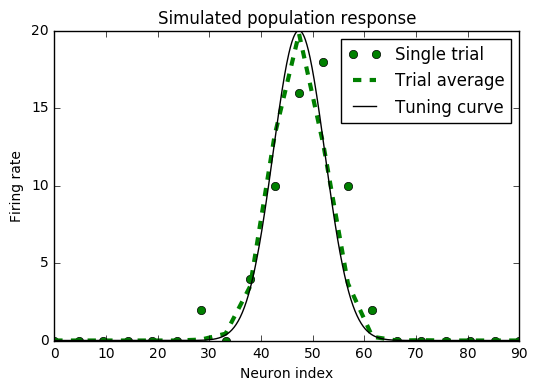

In [6]:
# Set up parameters of the simulation
T        = 0.5     
s_test   = s_0[n_neurons/2]
n_trials = 100

# Simulates different trials with the test stimulus using a Poisson spiking neuron
pop_spike_count = np.zeros((n_neurons, n_trials))
for n in range(n_neurons):
    rate = gauss_tuning(s_test,s_0[n],sigma,r_max)
    pop_spike_count[n,:] = np.random.poisson(rate * T, n_trials)

# Plot results
plt.plot(s_0, pop_spike_count[:,0]/T,'og')
plt.plot(s_0, np.mean(pop_spike_count,1)/T,'--g',linewidth=3)
plt.plot(s,   neuron_tuning[n_neurons/2,:], '-k')
plt.title('Simulated population response')
plt.xlabel('Neuron index')
plt.ylabel('Firing rate')
plt.legend(['Single trial','Trial average','Tuning curve'])

## 3. Maximum likelihood estimation
An question that arises now is if it is possible to read out the presented stimulus value after a single presentation. That is, we are trying to read out an estimate of a scalar stimuls value that was presented to the network, as opposed to the binary decision that was encountered in the likelihiod ratio test. One technique that can be used is maximum likelihood estimation. This works well if the full probability distribution of the responses is known. In the case of Gaussian tuning curves with equal variance and combined with Poisson spiking, it can be shown that the maximum likelihood estimate corresponds to

$$
s_{pred} = \dfrac{ \sum_{a} {r_as_a}} {\sum_{a}r_a}
$$

To see how good this technique performs, we can simulate the population response to different stimuli and test how much the true value deviates from the value predicted by maximul likelihood estimation.

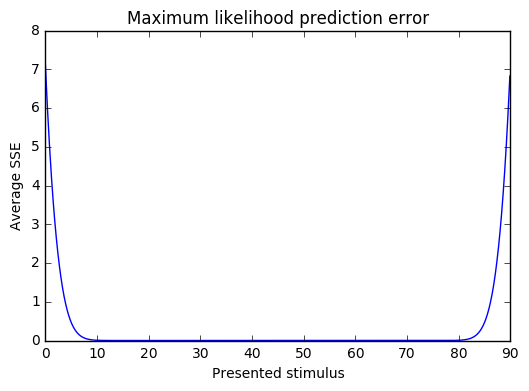

In [7]:
ml_error = np.zeros(len(s))
for i,stim in enumerate(s):
    rates = gauss_tuning(stim,s_0,sigma,r_max)
    
    for trial in range(n_trials):
        # Generate the population response
        counts = np.random.poisson(rates)
        
        # Derive the predicted stimulus value
        total_count    = np.sum(rates)
        weighted_count = np.sum(rates*s_0)
        s_predicted    = weighted_count/total_count
        
        # Calculate the predicted stimulus error
        ml_error[i] += (s_predicted-stim)**2
        
ml_error = ml_error/n_trials
plt.plot(s,ml_error)
plt.title('Maximum likelihood prediction error')        
plt.xlabel('Presented stimulus')
plt.ylabel('Average SSE')

# 4. Maximum A Posterio

The maximum likelihood method makes no assumptions about the prior stimulus distribution. If we do have prior information, it can be useful to construct a maximum a posterio estimate that takes this into account. If the stimulus distribution is Gaussian, then it can be shown that the MAP estimate corresponds to:

$$s_{pred} = \frac{T\sum{r_a s_a/ \sigma^2_a} + s_{prior} / \sigma^2_{prior}}{T\sum{r_a / \sigma^2_a} + 1 / \sigma^2_{prior}}$$

Assuming that we make observations for $$T = 1$$ second and that the stimulus distribution has unit variance, we can simplify the above equations somewhat:

$$s_{pred} = \frac{\sum{r_a s_a} + s_{prior} / \sigma^2_{prior}}{T\sum{r_a} + 1 / \sigma^2_{prior}}$$

In the following code we present the population of neurons with stimulus values sampled from a normal distribution with mean $s_{prior}$. Comparison of the ML method and MAP method shows that in this case, the MA method gives on average a slightly better estimate:

In [11]:
s_prior = 40
ma_error = 0
ml_error = 0
       
for trial in range(n_trials):
    stim = np.random.normal(s_prior,1)
    rates = gauss_tuning(stim,s_0,sigma,r_max)

    # Generate the population response
    counts = np.random.poisson(rates)

    # Derive the predicted stimulus value
    total_count    = np.sum(counts)
    weighted_count = np.sum(counts*s_0)
    ma_predicted    = (weighted_count + s_prior)/(total_count + 1)
    ml_predicted    = (weighted_count)/(total_count)
    
    # Calculate the predicted stimulus error
    ma_error += np.square(ma_predicted-stim)
    ml_error += np.square(ml_predicted-stim)

print(ml_error)
print(ma_error)

49.2333265423
47.6872047714
